# Sentinel-1 Water Extent Time Series
This notebook uses Sentinel-1 data to detect water extent and flooding. Since radar can penetrate clouds, it is possible to get consistent time series views of a region at 6-day or 12-day revisits based on the use of one or two Sentinel-1 missions. If the region of interest falls within a scene overlap, it may be possible to get even more frequent visits. This notebook includes several different data products including histograms to find a good threshold for water detection, a single date VH-band threshold product to identify water extent, and a multi-date change product to identify new flooding. The dataset is from the Microsoft Planetary Computer and includes radiometric terrain correction (RTC) so issues with viewing geometry and terrain slope are minimized. 

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio.features
from scipy.ndimage import uniform_filter, variance
from skimage.filters import threshold_minimum, threshold_otsu
from matplotlib.cm import jet_r

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer as pc
import odc
from odc.stac import stac_load

### Define the analysis region and time window

In [2]:
# Duck Lake - Vanuatu
ll = (-17.7382, 168.4090)
ur = (-17.7249, 168.4215)
time_of_interest = "2017-01-01/2025-03-01"

In [3]:
bbox = [ll[1], ll[0], ur[1], ur[0]]

Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes. 

In [4]:
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

In [5]:
# We will only load a specific orbit path (descending or ascending)

search = catalog.search(
    collections=["sentinel-1-rtc"], 
    bbox=bbox, 
    datetime=time_of_interest,
    query={"sat:orbit_state": {"eq": "ascending"}}
)

In [6]:
items = list(search.get_all_items()) # This produces a list of scene IDs

In [7]:
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 313


Next, we'll load the data into an XARRAY and then "clip" the data to only the pixels within our region (bounding box). We will only keep the desired bands (VV, VH). We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees and we have specified the spatial resolution of each pixel to be 10-meters, which is the baseline accuracy for this data. 

In [8]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
# The baseline resolution for Sentinel-1 = 10-meters
# Use larger values for screening data and faster execution times

resolution = 20  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

In [9]:
# Load the data using Open Data Cube
data = stac_load(items,bands=["vv", "vh"], patch_url=pc.sign, bbox=bbox, crs="EPSG:4326", resolution=scale, groupby="solar_day")

In [10]:
# View the details of our xarray dataset to be sure it is loaded properly
data

<xarray.Dataset> Size: 13MB
Dimensions:      (latitude: 75, longitude: 71, time: 313)
Coordinates:
  * latitude     (latitude) float64 600B -17.72 -17.73 -17.73 ... -17.74 -17.74
  * longitude    (longitude) float64 568B 168.4 168.4 168.4 ... 168.4 168.4
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 3kB 2017-01-22T07:12:40.627861 ... 202...
Data variables:
    vv           (time, latitude, longitude) float32 7MB 0.1924 ... 0.5047
    vh           (time, latitude, longitude) float32 7MB 0.09315 ... 0.0301

### Speckle Filtering using a Block Filter
Radar data is often "grainy" in appearance and differences between water and land are not consistent. To improve the data, it is quite common to use speckle filtering. Below is an algorithm that uses a common Lee filter to average the pixels surrounding any given pixel.

In [11]:
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    da_notime = da.squeeze()
    img = da_notime.values
    img_mean = uniform_filter(img, size)
    img_sqr_mean = uniform_filter(img**2, size)
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)

    # Convert numpy array back to xarray, flipping the Y axis
    output = xr.DataArray(img_output, dims=da_notime.dims, coords=da_notime.coords)
    
    return output

In [12]:
# The lee filter above doesn't handle null values
# We therefore set null values to 0 before applying the filter
valid = np.isfinite(data)
masked = data.where(valid, 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
# Select the filter size at the end of each line ... use odd numbers (3,5,7, etc).
data["filtered_vv"] = masked.vv.groupby("time").map(lee_filter, size=5)
data["filtered_vh"] = masked.vh.groupby("time").map(lee_filter, size=5)

# Null pixels should remain null
data['filtered_vv'] = data.filtered_vv.where(valid.vv)
data['filtered_vh'] = data.filtered_vh.where(valid.vh)

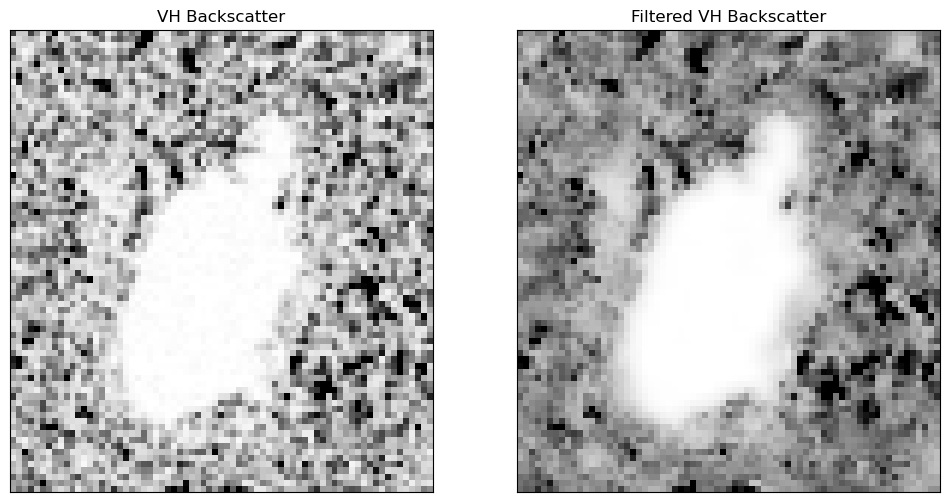

In [13]:
# Images appear smoother after speckle filtering
fig, ax = plt.subplots(1, 2, figsize=(12,6))
data["vh"].isel(time=0).plot(ax = ax[0],robust=True, cmap="Greys", add_colorbar=False)
data["filtered_vh"].isel(time=0).plot(ax = ax[1],robust=True, cmap="Greys", add_colorbar=False)
ax[0].set_title('VH Backscatter'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('Filtered VH Backscatter'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

### Convert the digital numbers to dB
While Sentinel-1 backscatter is provided as linear intensity, it is often useful to convert the backscatter to decible (dB) for analysis. 
Backscatter in dB unit has a more symmetric noise profile and less skewed value distribution for easier statistical evaluation.

In [14]:
data['filtered_vv'] = 10 * np.log10(data.filtered_vv)
data['filtered_vh'] = 10 * np.log10(data.filtered_vh)

## View Histogram Plots
Histogram plots are good for viewing the statistical backscatter distribution of the VV and VH data. In most cases it is easy to identify the difference between land pixels (higher values) and water pixels (lower values). VV-polarised backscatter may however sometimes be affected by wind and rain effects (which may cause a backscatter increase) which is why the VH polarisation channel is recommended for detection of water. The VH histogram in the example below will typically show land at a peak between -10dB and -15dB and a water (dark) peak between -20dB and -25dB. A reasonable threshold for water detection may be estimated from this histogram. 

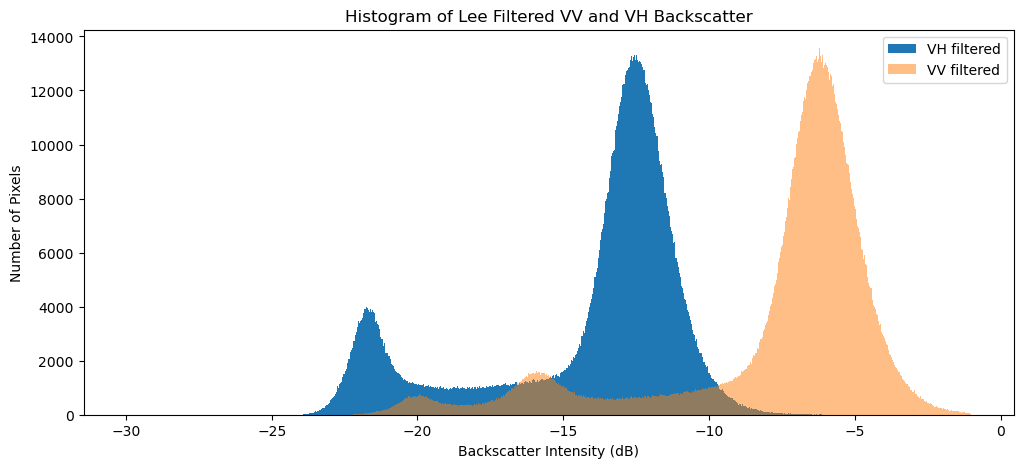

In [15]:
fig = plt.figure(figsize=(12, 5))
data.filtered_vh.plot.hist(bins=1000, range=(-30,-1), label="VH filtered")
data.filtered_vv.plot.hist(bins=1000, range=(-30,-1), label="VV filtered",alpha=0.5)
plt.legend()
plt.xlabel("Backscatter Intensity (dB)")
plt.ylabel("Number of Pixels")
plt.title("Histogram of Lee Filtered VV and VH Backscatter");

## Find a water threshold for the VH band
Here, we use the `threshod_minimum` function implemented in the `skimage` package to determine the threshold from the *VH* histogram automatically.
This method computes the histogram for all backscatter values, smooths it until there are only two maxima and find the minimum in between as the threshold.

In [16]:
vh_no_nans = data.filtered_vh.values[~np.isnan(data.filtered_vh.values)]
# threshold_vh = threshold_minimum(vh_no_nans)
threshold_vh = threshold_otsu(vh_no_nans)
print(threshold_vh)

-16.512957


In [17]:
# Manually override the threshold here
threshold_vh = -18.0

## View backscatter and false-color RGB outputs

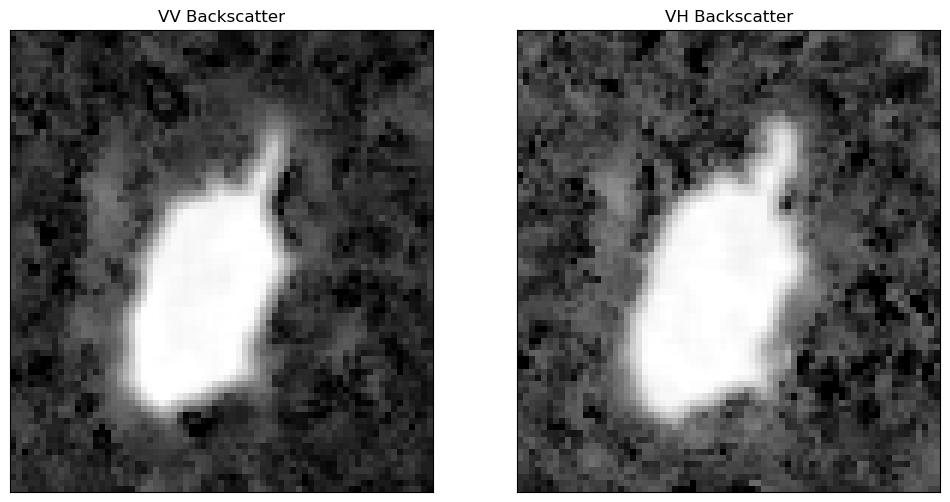

In [18]:
# Plots of VV and VH Backscatter Intensity
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
data["filtered_vv"].isel(time=0).plot(ax=ax[0],cmap='Greys',robust=True, add_colorbar=False)
data["filtered_vh"].isel(time=0).plot(ax=ax[1],cmap='Greys',robust=True, add_colorbar=False)
ax[0].set_title('VV Backscatter'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('VH Backscatter'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

In [19]:
# Adjust band data for improved RGB output
vv_new = data.vv / 6
vh_new = data.vh 
data['vv_new'] = vv_new 
data['vh_new'] = vh_new
data['vvvh_new'] = (vv_new / vh_new) / 30

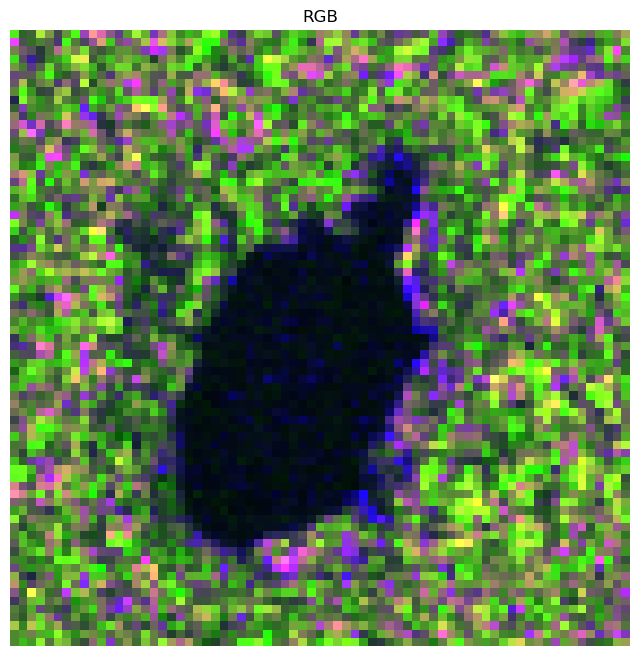

In [20]:
plot_data = data[["vv_new","vh_new","vvvh_new"]].to_array()
fig, ax = plt.subplots(figsize=(8,8))
plot_data.isel(time=0).plot.imshow(robust=True, ax=ax, vmin=0.0, vmax=0.1)
plt.title("RGB")
plt.axis('off')
plt.show()

## Single Date Single-Band Threshold Water Extent
The code below allows users to select a single date (index starts at ZERO), the VH band, and the calculated threshold value. The final product shows the water in BLUE color against a gray-scale VH-band background image. 

In [21]:
# Pick a time slice (starts at 0)
slice = 0

In [22]:
color_blue = np.array([0,0,255]) # Water (BLUE)
water = data.isel(time=slice).filtered_vh.values < threshold_vh

In [23]:
# Need to plot a blue water mask over a grey-scale VH image

In [24]:
def S1_water_classifier(da, threshold=threshold_vh):
    water_data_array = da < threshold
    return water_data_array.to_dataset(name="s1_water")

In [25]:
data['water'] = S1_water_classifier(data.filtered_vh).s1_water

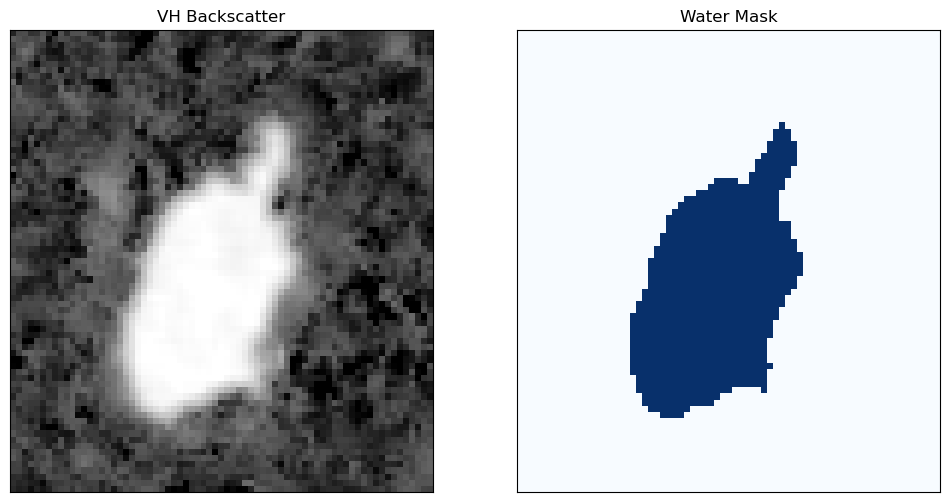

In [26]:
# Plots of VH and Water Mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
data["filtered_vh"].isel(time=slice).plot(ax=ax[0],cmap='Greys',robust=True, add_colorbar=False)
data["water"].isel(time=slice).plot(ax=ax[1], cmap='Blues', add_colorbar=False)
ax[0].set_title('VH Backscatter'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('Water Mask'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

## Time Series Water Extent

In [27]:
water_time = ((data.filtered_vh < threshold_vh))

In [28]:
out = []
for obj in water_time:
    total = obj.values.sum()*100/1000/1000
    day = [total]
    out.append(day)

In [29]:
water_pixels = out

In [30]:
scene = data.time.dt.date.values

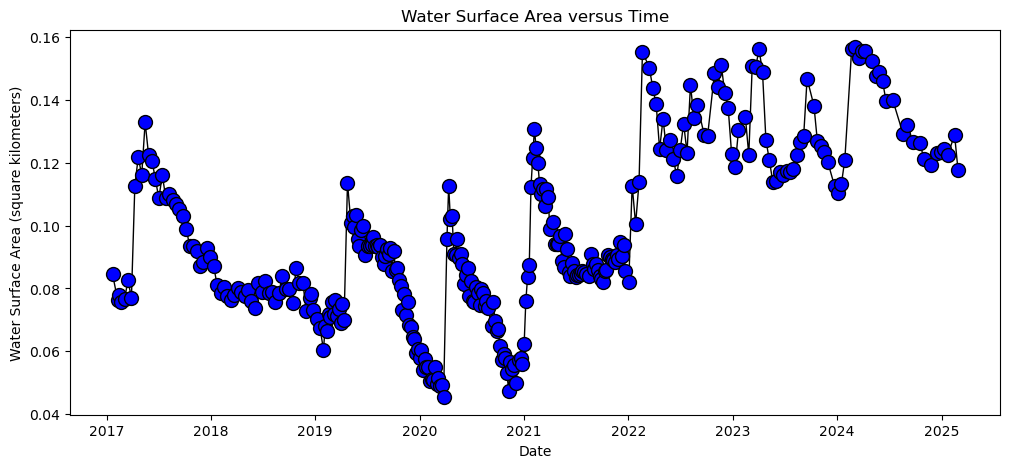

In [31]:
plt.figure(figsize=(12,5))
plt.plot(scene, water_pixels, c='black', marker='o', mfc='blue', markersize=10, linewidth=1)
plt.title('Water Surface Area versus Time')
plt.xlabel('Date')
plt.ylabel('Water Surface Area (square kilometers)')
plt.show()